Shape of items_df_item_name_text_features : (22170, 25)


C:\Users\whitebye\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



shop_name
item_category_name
item_name
RMSE on Validation hold out month 33: 0.27841182809545306
Accuracy on training data without considering variable importances:68.15
Variable: item_cnt_month_mean  Importance: 0.71
Variable: date_block_num       Importance: 0.09
Variable: item_cnt_prev_month  Importance: 0.03
Variable: item_id              Importance: 0.02
Variable: item_name            Importance: 0.02
Variable: item_name_length     Importance: 0.02
Variable: year                 Importance: 0.01
Variable: item_name_word_count Importance: 0.01
Variable: item_name_tfidf_21   Importance: 0.01
Variable: item_category_name_tfidf_6 Importance: 0.01
Variable: shop_id              Importance: 0.0
Variable: item_category_id     Importance: 0.0
Variable: item_name_tfidf_0    Importance: 0.0
Variable: item_name_tfidf_1    Importance: 0.0
Variable: item_name_tfidf_2    Importance: 0.0
Variable: item_name_tfidf_3    Importance: 0.0
Variable: item_name_tfidf_4    Importance: 0.0
Variable: item_

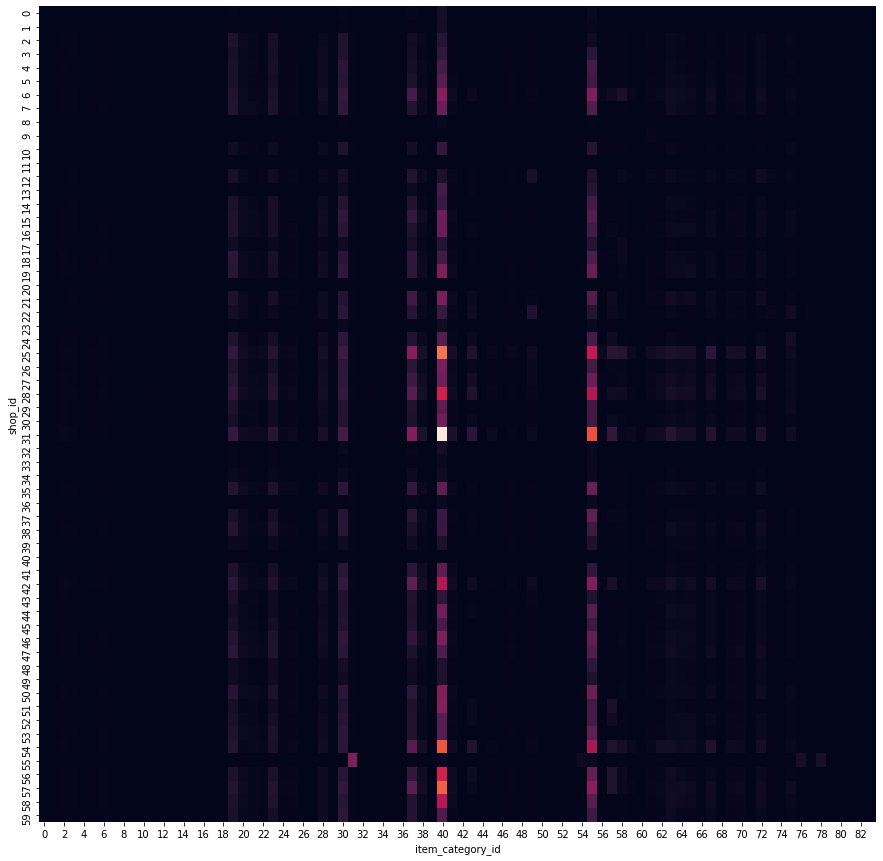

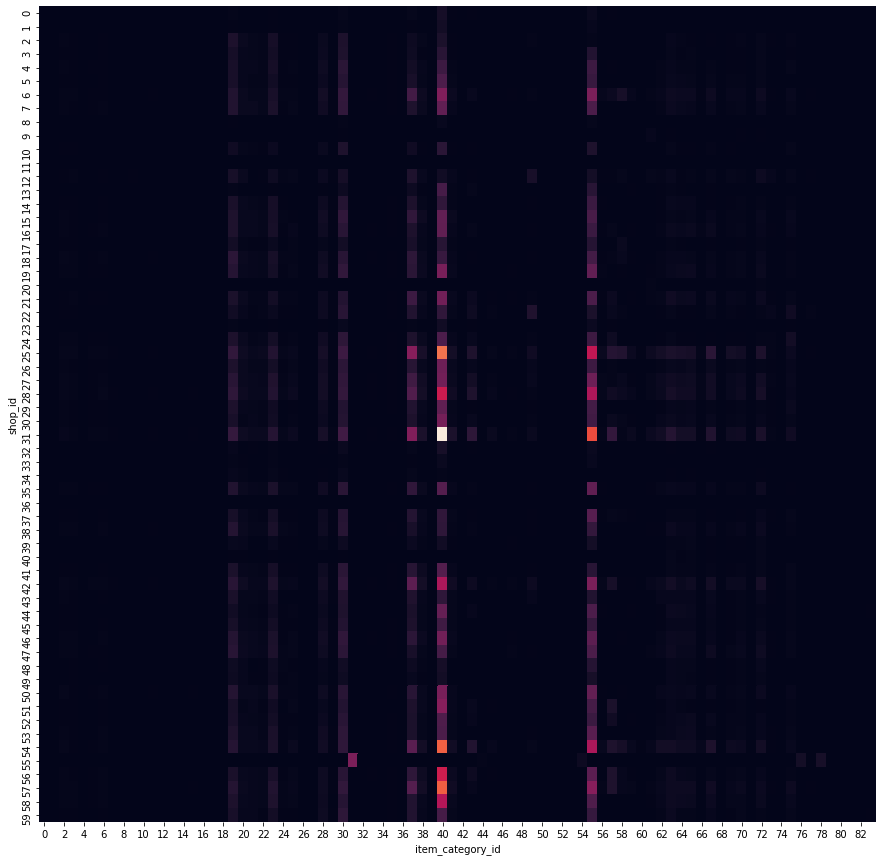

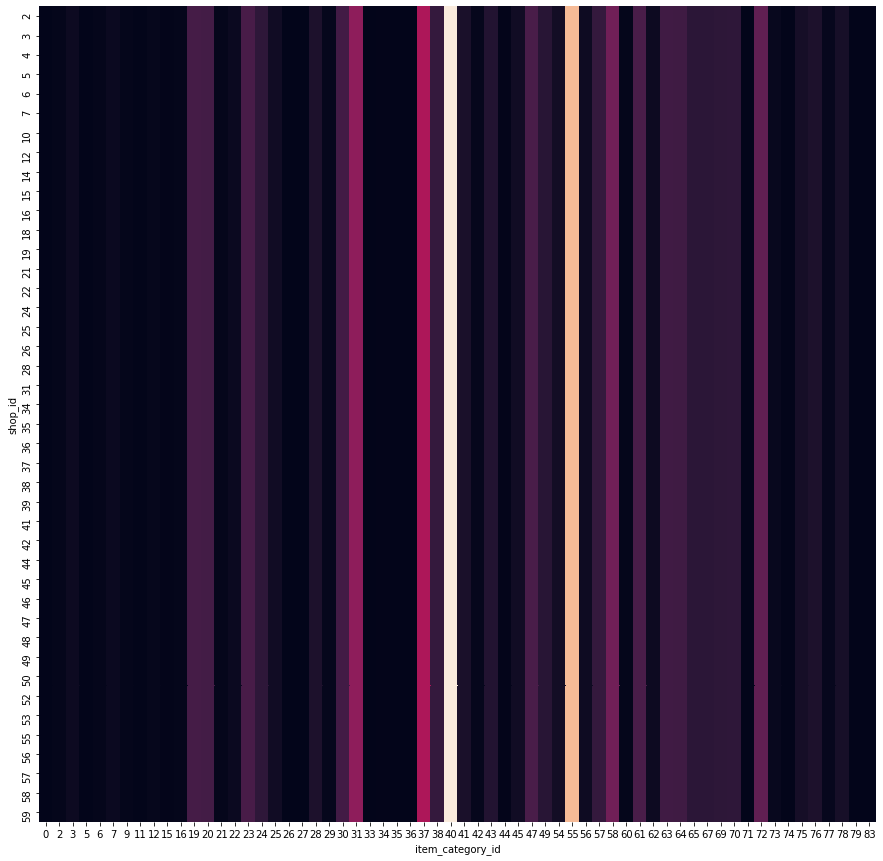

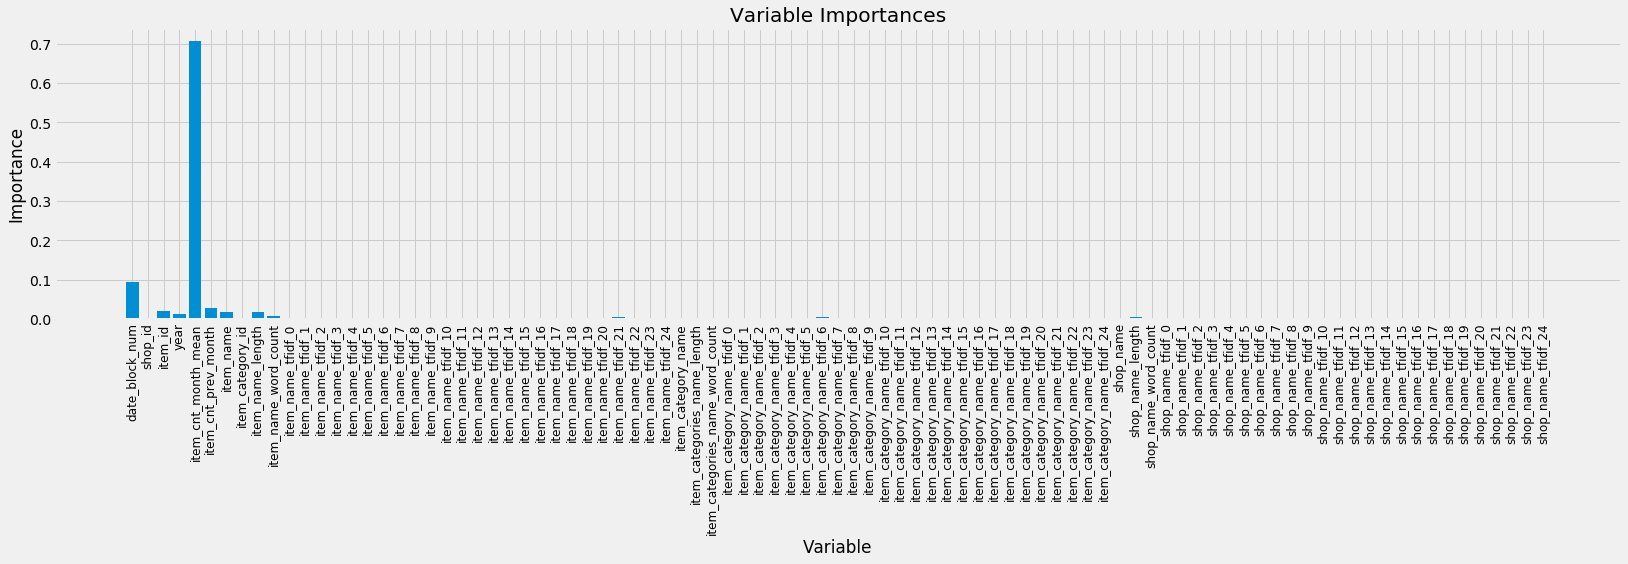

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import datetime

train_df = pd.read_csv("../Data/sales_train.csv")
test_df = pd.read_csv("../Data/test.csv")
submission_df = pd.read_csv("../Data/sample_submission.csv")
items_df = pd.read_csv("../Data/items.csv")
item_categories_df = pd.read_csv("../Data/item_categories.csv")
shops_df = pd.read_csv("../Data/shops.csv")

feature_count = 25
items_df['item_name_length'] = items_df['item_name'].map(lambda x : len(x)) #Length of each item_name(including punctuation in the item_name)
items_df['item_name_word_count'] = items_df['item_name'].map(lambda x : len(x.split(' '))) #Number of words/group of characters seperated by a whitespace
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(max_features=feature_count) #tfidf = term frequency inverse document frequency
items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_df['item_name']).toarray())
print("Shape of items_df_item_name_text_features : {}".format(items_df_item_name_text_features.shape))
cols = items_df_item_name_text_features.columns
for idx in range(feature_count):
    items_df['item_name_tfidf_' + str(idx)] = items_df_item_name_text_features[cols[idx]]

feature_count = 25
item_categories_df['item_categories_name_length'] = item_categories_df['item_category_name'].map(lambda x : len(x)) #Length of each item_category_name(including punctuation in the item_category_name)
item_categories_df['item_categories_name_word_count'] = item_categories_df['item_category_name'].map(lambda x : len(x.split(' '))) #Number of words/group of characters seperated by a whitespace
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(max_features=feature_count) #tfidf = term frequency inverse document frequency
item_categories_df_item_category_name_text_features = pd.DataFrame(tfidf.fit_transform(item_categories_df['item_category_name']).toarray())
cols = item_categories_df_item_category_name_text_features.columns
for idx in range(feature_count):
    item_categories_df['item_category_name_tfidf_' + str(idx)] = item_categories_df_item_category_name_text_features[cols[idx]]


feature_count = 25
shops_df['shop_name_length'] = shops_df['shop_name'].map(lambda x : len(x)) #Length of each shop_name(including punctuation in the shop_name)
shops_df['shop_name_word_count'] = shops_df['shop_name'].map(lambda x : len(x.split(' '))) #Number of words/group of characters seperated by a whitespace
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(max_features=feature_count) #tfidf = term frequency inverse document frequency
shops_df_shop_name_text_features = pd.DataFrame(tfidf.fit_transform(shops_df['shop_name']).toarray())
cols = shops_df_shop_name_text_features.columns
for idx in range(feature_count):
    shops_df['shop_name_tfidf_' + str(idx)] = shops_df_shop_name_text_features[cols[idx]]


#turn data into monthly data
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df = train_df.drop(['date', 'item_price'], axis=1)
train_df = train_df.groupby([c for c in train_df.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train_df = train_df.rename(columns={'item_cnt_day':'item_cnt_month'})

#Monthly mean
shop_item_monthly_mean = train_df[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})

#Add Mean Features
train_df = pd.merge(train_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])

#Last Month : Oct 2015
shop_item_prev_month = train_df[train_df['date_block_num'] == 33][['shop_id', 'item_id', 'item_cnt_month']]
shop_item_prev_month = shop_item_prev_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})
shop_item_prev_month.head()

#Add the above previous month features
train_df = pd.merge(train_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])

np.where(pd.isnull(train_df))

train_df = train_df.fillna(0.)

#Add Item, Category and Shop features
train_df = pd.merge(train_df, items_df, how='left', on='item_id')

train_df = pd.merge(train_df, item_categories_df, how='left', on=['item_category_id'])

train_df = pd.merge(train_df, shops_df, how='left', on=['shop_id'])

#Manipulate test data
test_df['month'] = 11
test_df['year'] = 2015
test_df['date_block_num'] = 34

test_df = pd.merge(test_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])

#Add previous month features
test_df = pd.merge(test_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])

#Items features
test_df = pd.merge(test_df, items_df, how='left', on='item_id')

#Item Category features
test_df = pd.merge(test_df, item_categories_df, how='left', on='item_category_id')
#Shops features
test_df = pd.merge(test_df, shops_df, how='left', on='shop_id')
test_df = test_df.fillna(0.)
test_df['item_cnt_month'] = 0.


#可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
stores_hm = train_test_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
stores_hm.tail()

#Heatmap of "item_cnt_month" in "shop_id vs item_category_id" in "train_test_df"
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(stores_hm, ax=ax, cbar=False)

#Heatmap of "item_cnt_month" in "shop_id vs item_category_id" in "train_df"
stores_hm = train_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(stores_hm, ax=ax, cbar=False)

#Heatmap of "item_cnt_month" in "shop_id vs item_category_id" in "test_df"
stores_hm = test_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(stores_hm, ax=ax, cbar=False)

for c in ['shop_name', 'item_category_name', 'item_name']:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(list(train_df[c].unique()) + list(test_df[c].unique()))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test_df[c].astype(str))
    print(c)


feature_list = [c for c in train_df.columns if c not in 'item_cnt_month']
#Validation hold out month is 33
x1 = train_df[train_df['date_block_num'] < 33]
y1 = np.log1p(x1['item_cnt_month'].clip(0., 20.))
x1 = x1[feature_list]
x2 = train_df[train_df['date_block_num'] == 33]
y2 = np.log1p(x2['item_cnt_month'].clip(0., 20.))
x2 = x2[feature_list]

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, n_jobs=-1)#use n_estimators=25, max_depth=15, random_state=42(for consistent results)
rf.fit(x1, y1)
print("RMSE on Validation hold out month 33: {}".format(np.sqrt(sklearn.metrics.mean_squared_error(y2.clip(0., 20.), rf.predict(x2).clip(0., 20.)))))

#Full train
rf.fit(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))
print("Accuracy on training data without considering variable importances:{}".format(round(rf.score(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))*100, 2)))

#predict
test_df['item_cnt_month'] = rf.predict(test_df[feature_list]).clip(0., 20.)

#create submission file
test_df[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)

from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

#To see the decision tree in action, visualizing with a smaller one for illustrative purposes
rf_small = RandomForestRegressor(n_estimators=2, random_state=42, max_depth=3, n_jobs=-1)
rf_small.fit(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))
small_tree = rf_small.estimators_[1]
export_graphviz(small_tree, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')
Image(filename='small_tree.png')

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


# Set the style
plt.style.use('fivethirtyeight')

#set size
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
ax.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical', fontsize=12)

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');



rf_most_important = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, n_jobs=-1)

# Extract the ten most important features
important_features = ['item_cnt_month_mean', 'date_block_num', 'item_cnt_prev_month', 'item_id', 'item_name', 'item_name_length', 'year', 'item_name_word_count', 'item_name_tfidf_21', 'item_category_name_tfidf_6']

#Full train
rf_most_important.fit(train_df[important_features], train_df['item_cnt_month'].clip(0., 20.))
print("Accuracy on training data considering variable importances:{}".format(round(rf_most_important.score(train_df[important_features], train_df['item_cnt_month'].clip(0., 20.))*100, 2)))

#predict
test_df['item_cnt_month'] = rf_most_important.predict(test_df[important_features]).clip(0., 20.)

#create submission file
test_df[['ID', 'item_cnt_month']].to_csv('submission_variable_importance.csv', index=False)